In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from enum import Enum
from typing import List, Union
import ipywidgets as widgets

import time
import random
import math
from scipy.spatial import ConvexHull

from shapely.geometry import Polygon

# Implementation of GJK

## Vec2D class

In [2]:
class Vec2D:
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Vec3D(self.x + other.x, self.y + other.y)

    def __sub__(self, other):
        return Vec2D(self.x - other.x, self.y - other.y)
    
    def __neg__(self):
        return Vec2D(-self.x, -self.y)
    
    def normal(self):
        _abs = abs(self)
        return Vec2D(-self.y/_abs, self.x/_abs)
    
    def dot(self, other) -> float:        
        return self.x * other.x + self.y * other.y

    def __eq__(self, other):
        return abs(self - other) < 1e-6

    def __str__(self):
        return '(%g, %g)' % (self.x, self.y)

    def __abs__(self):
        return math.sqrt(self.x**2 + self.y**2)

    def __ne__(self, other):
        return not self.__eq__(other)

## Simplex structure

We use this structure not to consider the whole Minkowski Difference

In [3]:
class SimplexType(Enum):
    Zero = 0
    Point = 1
    Line = 2
    Triangle = 3

class Simplex:
    def __init__(self, points: List[Vec2D] = None):
        self._points = [] if points is None else points

    def push_front(self, point: Vec2D):        
        self._points = [point, *self._points]
                
        if self.size() > 3:
            self._points = [self._points[0], self._points[1], self._points[2]]

    def __getitem__(self, i: int) -> Vec2D:
        return self._points[i]

    def size(self) -> int:
        return len(self._points)

    def __iter__(self):
        return iter(self._points)

    def type(self) -> SimplexType:
        return SimplexType(self.size())
    
    def __str__(self):
        res = "["
        for p in self._points:
            res += str(p) + " "    
        res += "]"
        
        return res

## Body structure

This structure represents the object: sets of 2D points in space

In [4]:
class Body:
    def __init__(self, hitBox: List[Vec2D] = None):
        self._hitBox = [] if hitBox is None else hitBox
        
        if(type(hitBox) == np.ndarray):
            self._hitBox = [Vec2D(p[0], p[1]) for p in hitBox]
        
    def draw(self):
        x_list = [v.x for v in self._hitBox]
        y_list = [v.y for v in self._hitBox]
        
        # add the first point to close the figure
        x_list.append(self._hitBox[0].x)
        y_list.append(self._hitBox[0].y)
        
        plt.fill_between(x_list, y_list, alpha=0.2)
        plt.plot(x_list, y_list)
        
        return x_list, y_list
    
    def size(self) -> int:
        return len(self._hitBox)

    def _find_furthest_point(self, direction):
        max_point = Vec2D()
        max_distance = float('-inf')

        for point in self._hitBox:
            distance = point.dot(direction)

            if distance > max_distance:
                max_distance = distance
                max_point = point

        return max_point

    def _support(self, obj, direction: Vec2D) -> Vec2D:
        p1 = self._find_furthest_point(direction)
        p2 = obj._find_furthest_point(-direction)

        return p1 - p2
        
    @staticmethod
    def _next_simplex(simplex):
        simplex_type = simplex.type()

        if simplex_type == SimplexType.Line:
            return Body._line_case(simplex)
        elif simplex_type == SimplexType.Triangle:
            return Body._triangle_case(simplex)
        else:
            raise ValueError("Body::next_simplex: simplex is not Line or Triangle")

    @staticmethod
    def _line_case(simplex):
        
        new_simplex = simplex
        new_direction = Vec2D()

        a = simplex[0]
        b = simplex[1]

        ab = b - a
        ao = -a
        
        ab_n = ab.normal()

        if ab.dot(ao) > 0:
            new_direction = ab_n if ab_n.dot(ao) > 0 else -ab_n
        else:
            new_simplex = Simplex([a])
            new_direction = ao

        return new_simplex, new_direction, False

    @staticmethod
    def _triangle_case(simplex):
                
        new_simplex = simplex
        new_direction = Vec2D()

        a = simplex[0]
        b = simplex[1]
        c = simplex[2]

        ab = b - a
        ac = c - a
        ao = -a
        
        ac_n = ac.normal()

        if ac_n.dot(ao) > 0:
            if ac.dot(ao) > 0:
                new_simplex = Simplex([a, c])
                new_direction = ac_n
            else:
                return Body._line_case(Simplex([a, b]))
        else:
            if ab.normal().dot(ao) < 0:
                '''
                plt.xlim(-10, 10)
                plt.ylim(-10, 10)
                plt.scatter(0, 0, c='black')
                Body(new_simplex).draw()
                '''
                # here we need to reverse the order because we can find the next
                # point only in the direction of the -normal of AB
                return Body._line_case(Simplex([b, a]))
            else:
                # Collision detected
                '''
                plt.xlim(-10, 10)
                plt.ylim(-10, 10)
                plt.scatter(0, 0, c='black')
                Body(new_points).draw()
                '''
                return new_simplex, Vec2D(), True
        
        return new_simplex, new_direction, False
    
    @staticmethod
    def draw_several(shapes):
        for shape in shapes:
            shape.draw()

    def check_collision_gjk(self, obj):
        
        # Get initial support point in any direction
        support = self._support(obj, Vec2D(1, 0))

        # Simplex is an array of points, max count is 4
        simplex = Simplex()
        simplex.push_front(support)

        # New direction is towards the origin
        direction = -support

        iters = 0
        while iters < self.size() + obj.size():
            iters += 1
            support = self._support(obj, direction)

            if support.dot(direction) <= 0:
                return False, simplex  # no collision

            simplex.push_front(support)

            new_simplex, new_direction, is_found = Body._next_simplex(simplex)

            direction = new_direction
            simplex = new_simplex
            
            if is_found:
                return True, simplex
        

        return False, simplex

In [5]:
def test_collision(x_shift=2.40, y_shift=-0.30):
    body2 = Body([Vec2D(-1+x_shift, -1+y_shift), Vec2D(0+x_shift, 1+y_shift), Vec2D(1+x_shift, -1+y_shift)])
    body1 = Body([Vec2D(-1, -1), Vec2D(0, 1), Vec2D(1, 1), Vec2D(2, -1)])
    
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    Body.draw_several([body1, body2])
    
    is_collision, _ = body1.check_collision_gjk(body2)
    print("Collision =", is_collision)

In [6]:
# simple example with trangle and parallelogram 
#widgets.interact(test_collision, x_shift=(-3.0, 3.0, 0.3), y_shift=(-3.0, 3.0, 0.3))

## Generator of random convex shapes

In [7]:
def generate_random_convex_shape(num_points, plot=False):
    # Ensure num_points is at least 3 for a valid convex hull
    num_points = max(3, num_points)
    
    # Generate random points
    points = np.array([(random.uniform(-5, 5), random.uniform(-5, 5)) for _ in range(num_points)])
        
    # Compute the convex hull
    hull = ConvexHull(points)
        
    if len(hull.vertices) < num_points:
        # we need more points to generate convex shape:
        while len(hull.vertices) < num_points:
            new_points = np.concatenate((points, np.array([(random.uniform(-10, 10), random.uniform(-10, 10))])))
            new_hull = ConvexHull(new_points)
            
            if len(new_hull.vertices) > len(hull.vertices):
                hull = new_hull
                points = new_points
        
    pos = np.array([random.uniform(-1, 1)*num_points, random.uniform(-1, 1)*num_points])
    points = points[hull.vertices] + pos
    
    # Plot the convex shape
    if plot:
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        
        x_list = [v[0] for v in points]
        y_list = [v[1] for v in points]
        # add the first point to close the figure
        x_list.append(points[0, 0])
        y_list.append(points[0, 1])
        plt.plot(x_list, y_list, marker = 'o')

        plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
        plt.show()
    
    return points

# Example: Generate a random convex shape with exactly 5 points
shape1 = generate_random_convex_shape(40)

In [8]:
def test_collision(points1=10, points2=10, pos1x=0.0, pos1y=0.0, seed=300):
    random.seed(seed)
    
    v1 = generate_random_convex_shape(points1) + np.array([pos1x, pos1y])
    v2 = generate_random_convex_shape(points2)
    
    body2 = Body(v1)
    body1 = Body(v2)
    
    p1 = Polygon(v1)
    p2 = Polygon(v2)
    
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    Body.draw_several([body1, body2])
    
    is_collision, _ = body1.check_collision_gjk(body2)
    print("GJK answer =", is_collision)
    print("shapely answer =", p1.intersects(p2))

In [10]:
# interactive example
'''
widgets.interact(test_collision, 
                 points1=(3, 10, 1),
                 points2=(3, 10, 1), 
                 pos1x=(-10, 10, 0.1), 
                 pos1y=(-10, 10, 0.1),
                 seed=(0, 1000, 100))
                 '''

'\nwidgets.interact(test_collision, \n                 points1=(3, 10, 1),\n                 points2=(3, 10, 1), \n                 pos1x=(-10, 10, 0.1), \n                 pos1y=(-10, 10, 0.1),\n                 seed=(0, 1000, 100))\n                 '

## Test with many random shapes

In [11]:
def testGJK(seed=211, min_points=3, max_points=10, iterations_per_numbers=1000):
    random.seed(seed)
    
    yes = []
    no = []
    incorrect = []
    correct = []
    
    for points1 in range(min_points, max_points+1):
        for points2 in range(min_points, max_points+1):
            for i in range(iterations_per_numbers):
                
                v1 = generate_random_convex_shape(points1)
                v2 = generate_random_convex_shape(points2)
    
                body1 = Body(v1)
                body2 = Body(v2)
    
                p1 = Polygon(v1)
                p2 = Polygon(v2)
            
                intersects = p1.intersects(p2)
                
                if intersects:
                    yes.append([v1, v2])
                else:
                    no.append([v1, v2])
                    
                is_collision, _ = body1.check_collision_gjk(body2)
                
                if is_collision == intersects:
                    correct.append([v1, v2])
                else:
                    incorrect.append([v1, v2])
            
            w = max_points+1-min_points
            h = w
            print("progress:", 100*((points1-min_points)*w + points2-min_points)/(w*h), end="\r")
    
    return correct, incorrect, yes, no

In [20]:
correct, incorrect, yes, no = testGJK()

In [21]:
print("correct:", len(correct))
print("incorrect:", len(incorrect))
print("yes:", len(yes))
print("no:", len(no))

correct: 64000
incorrect: 0
yes: 34461
no: 29539


## Examples of intersections

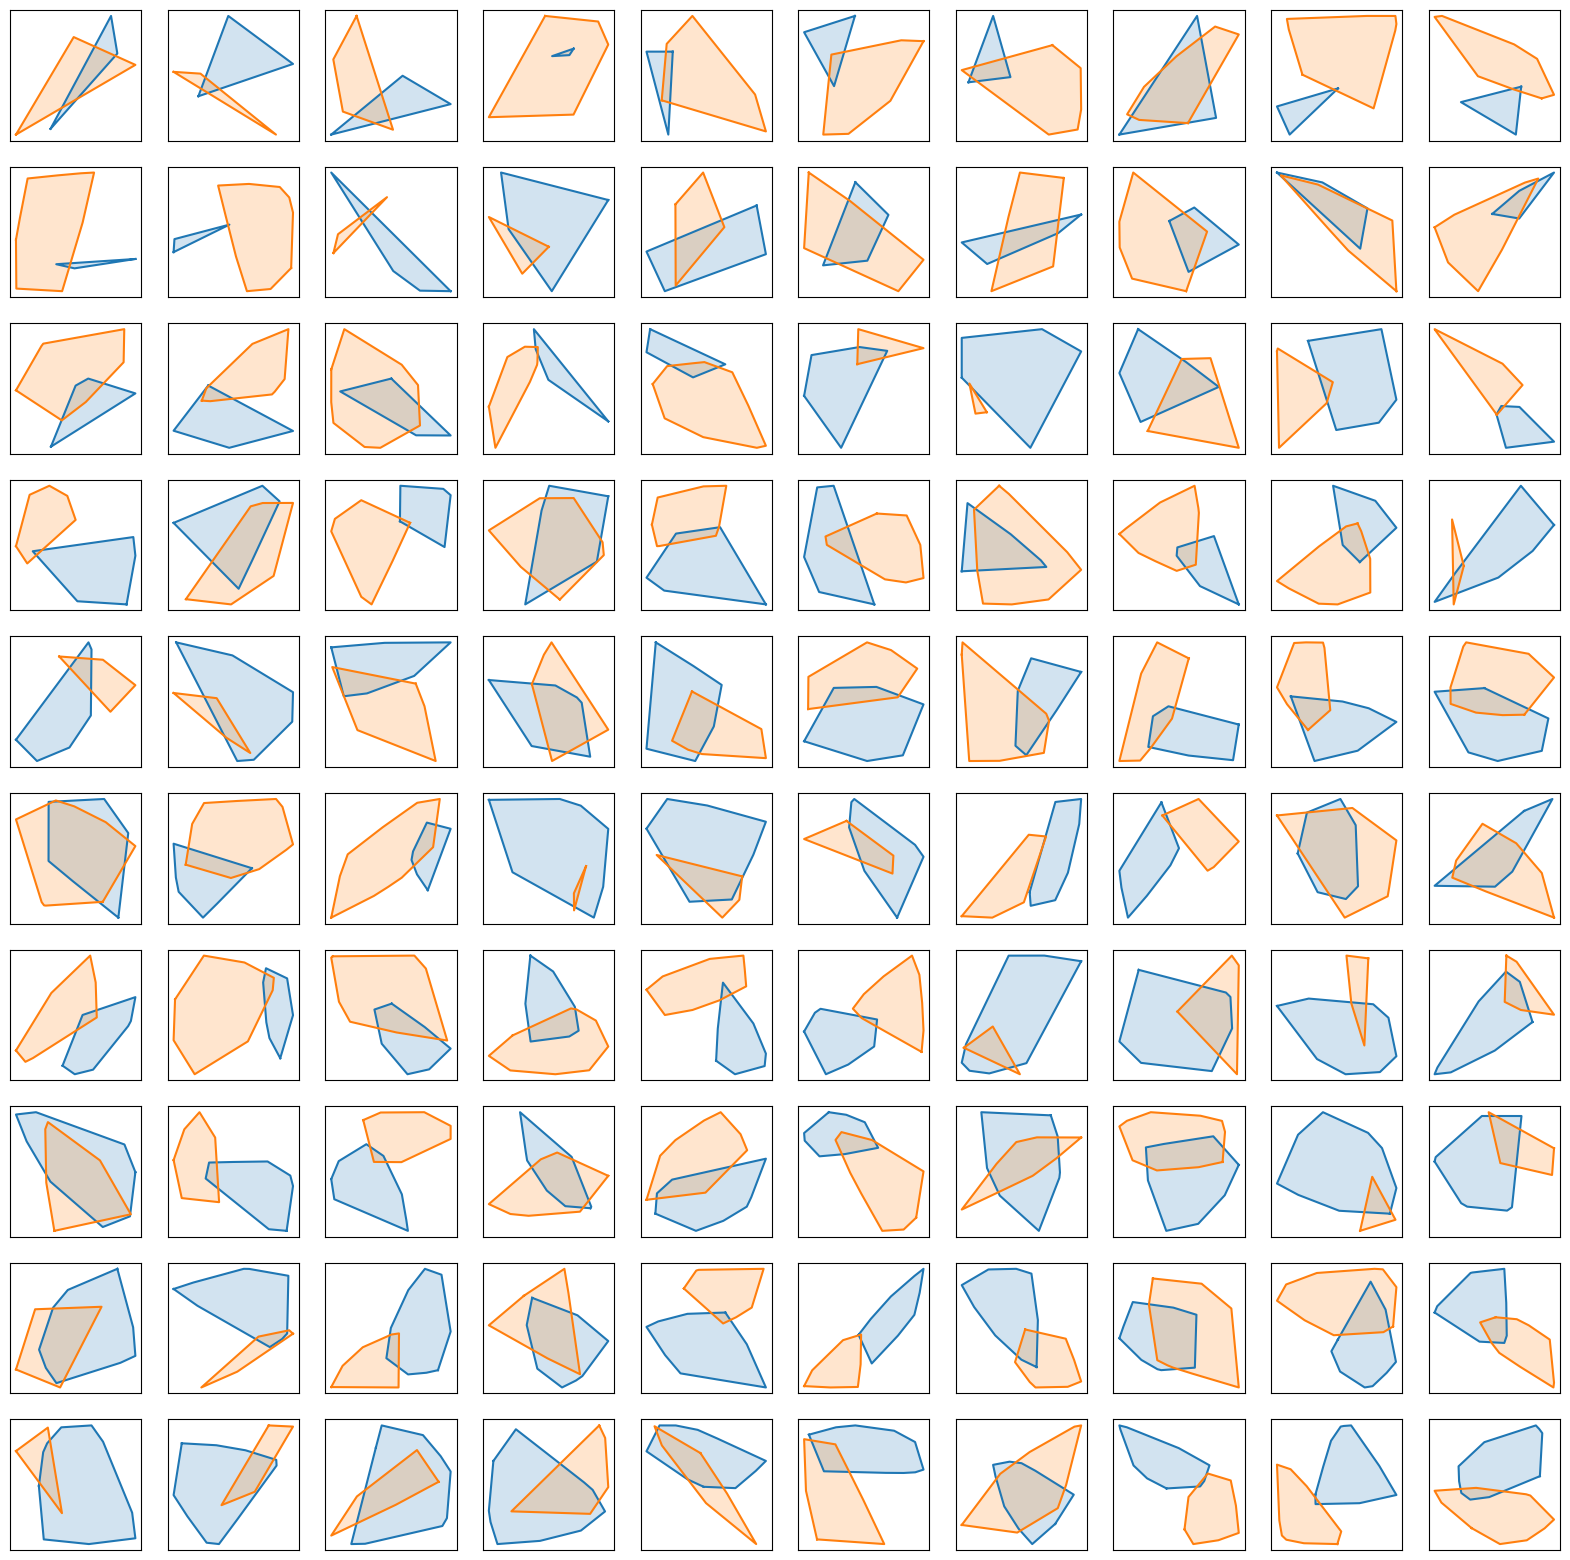

In [22]:
plt.figure(figsize=(20,20))

for i in range(100):
    
    plt.subplot(10, 10, i+1)
    
    el = int(i*len(yes)/100)
    Body.draw_several([Body(yes[el][0]), Body(yes[el][1])])
    plt.xticks([])
    plt.yticks([])

plt.savefig("plots/rand_inters.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Examples of no intersections

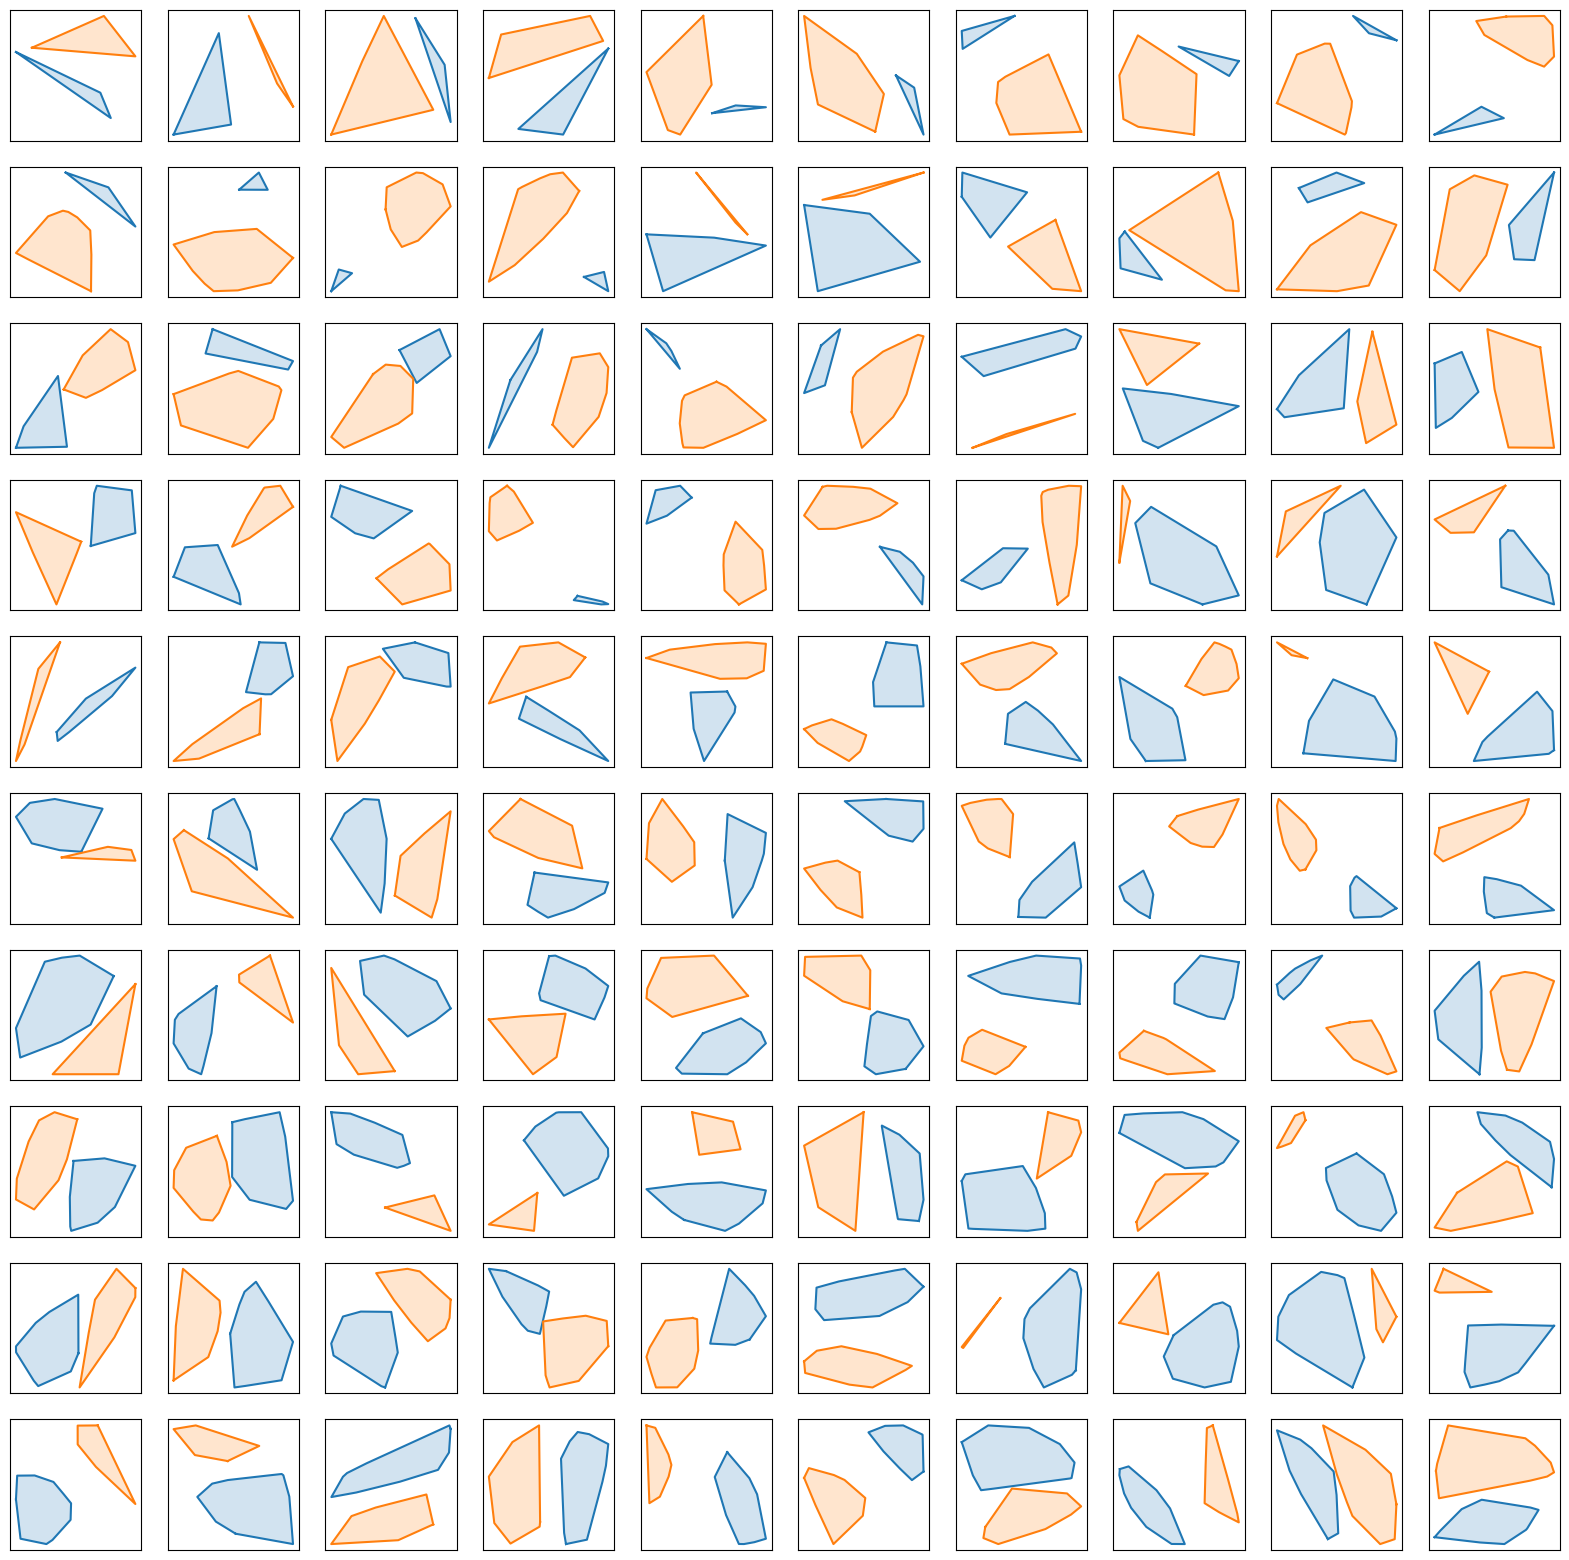

In [23]:
plt.figure(figsize=(20,20))

for i in range(100):
    
    plt.subplot(10, 10, i+1)
    
    el = int(i*len(no)/100)
    Body.draw_several([Body(no[el][0]), Body(no[el][1])])
    plt.xticks([])
    plt.yticks([])

plt.savefig("plots/rand_no_inters.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Generator of random Regular polygons with random size, position and rotation

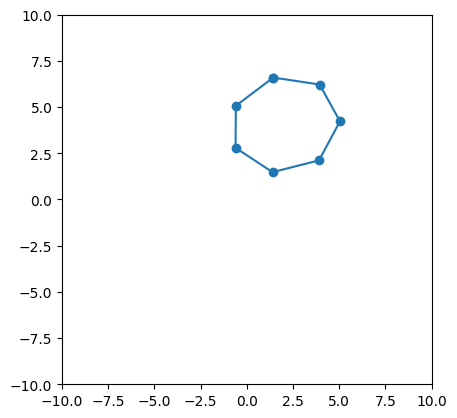

In [12]:
def generate_random_regular_polygon(num_points, plot=False):
    # Ensure num_points is at least 3 for a valid convex hull
    num_points = max(3, num_points)
    
    # Generate random size, angle and position
    w = random.uniform(0, 5)
    h = random.uniform(0, 5)
    phi = random.uniform(0, 2*np.pi)
    pos = np.array([random.uniform(-5, 5), random.uniform(-5, 5)])
    
    # Generate points
    points = []
    for alpha in np.arange(0, 2*np.pi, 2*np.pi/num_points):
        points.append([w*np.cos(alpha), h*np.sin(alpha)])
    
    rotation_matrix = np.array([[np.cos(phi), -np.sin(phi)],
                                [np.sin(phi), np.cos(phi)]])
    
    points = np.array(points)@rotation_matrix + pos
    
    # Plot the convex shape
    if plot:
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)

        x_list = [v[0] for v in points]
        y_list = [v[1] for v in points]
        # add the first point to close the figure
        x_list.append(points[0, 0])
        y_list.append(points[0, 1])
        plt.plot(x_list, y_list, marker = 'o')

        plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
        plt.show()
    
    return points

# Example: Generate a random convex shape with exactly 5 points
shape1 = generate_random_regular_polygon(7, True)

## Test with many random shapes

In [13]:
def testGJK_regular(seed=211, min_points=3, max_points=30, iterations_per_numbers=1000):
    random.seed(seed)
    
    yes = []
    no = []
    incorrect = []
    correct = []
    
    for points1 in range(min_points, max_points+1):
        for points2 in range(min_points, max_points+1):
            for i in range(iterations_per_numbers):
                
                v1 = generate_random_regular_polygon(points1)
                v2 = generate_random_regular_polygon(points2)
    
                body1 = Body(v1)
                body2 = Body(v2)
    
                p1 = Polygon(v1)
                p2 = Polygon(v2)
            
                intersects = p1.intersects(p2)
                
                if intersects:
                    yes.append([v1, v2])
                else:
                    no.append([v1, v2])
                    
                is_collision, _ = body1.check_collision_gjk(body2)
                
                if is_collision == intersects:
                    correct.append([v1, v2])
                else:
                    incorrect.append([v1, v2])
            
            w = max_points+1-min_points
            h = w
            print("progress:", 100*((points1-min_points)*w + points2-min_points)/(w*h), end="\r")
    
    return correct, incorrect, yes, no

In [36]:
correct, incorrect, yes, no = testGJK_regular()

In [37]:
print("correct:", len(correct))
print("incorrect:", len(incorrect))
print("yes:", len(yes))
print("no:", len(no))

correct: 784000
incorrect: 0
yes: 342125
no: 441875


## Handle of incorrect results

In [38]:
# Examples of incorrect
for inc in incorrect:
    b1 = Body(inc[0])
    b2 = Body(inc[1])

    Body.draw_several([b1, b2])
    plt.show()
    print(b1.check_collision_gjk(b2))

## Examples of intersections

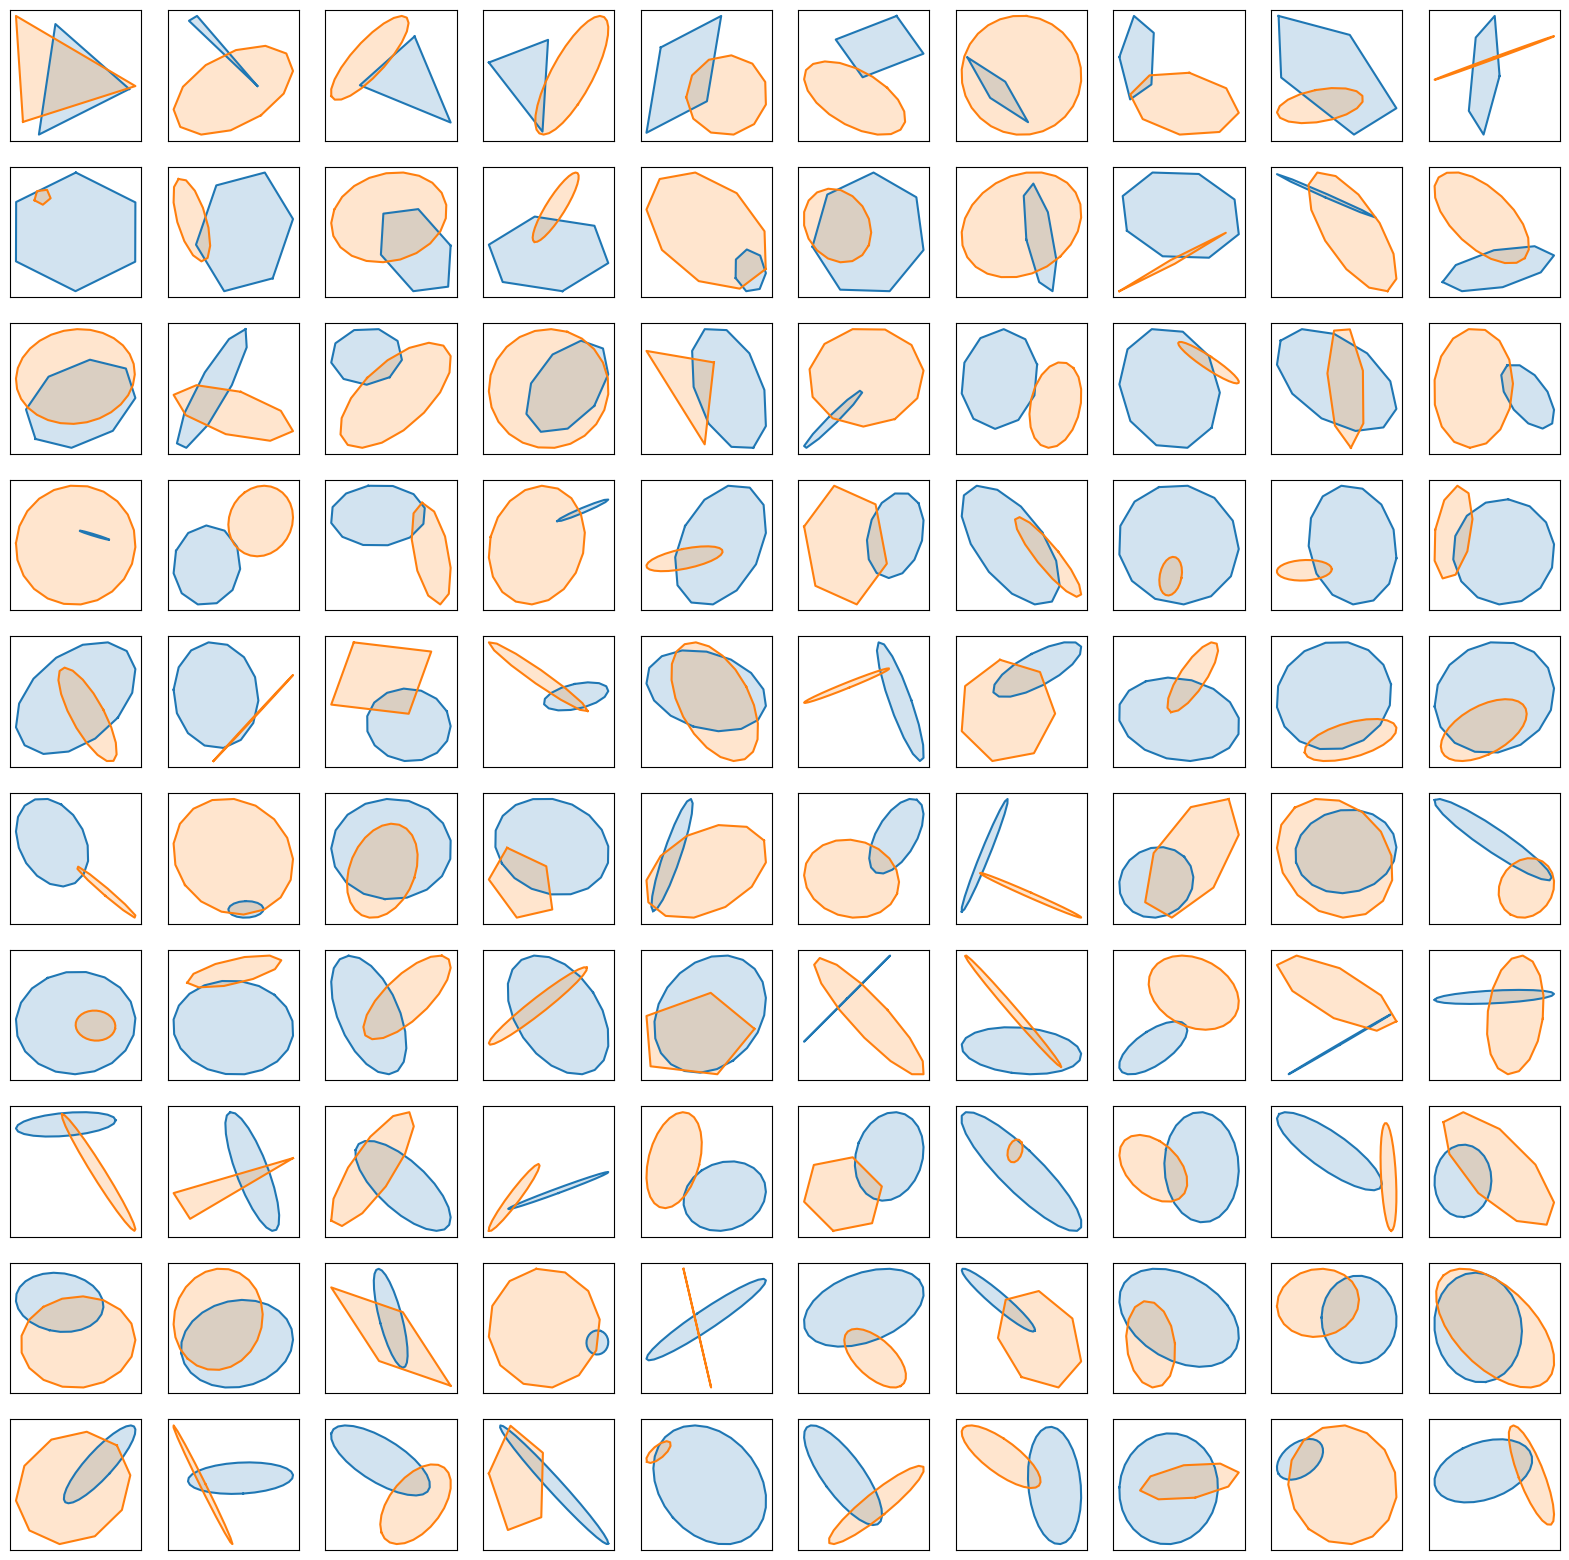

In [39]:
plt.figure(figsize=(20,20))

for i in range(100):
    
    plt.subplot(10, 10, i+1)
    
    el = int(i*len(yes)/100)
    Body.draw_several([Body(yes[el][0]), Body(yes[el][1])])
    plt.xticks([])
    plt.yticks([])

plt.savefig("plots/rand_inters_regular.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Examples of no intersections

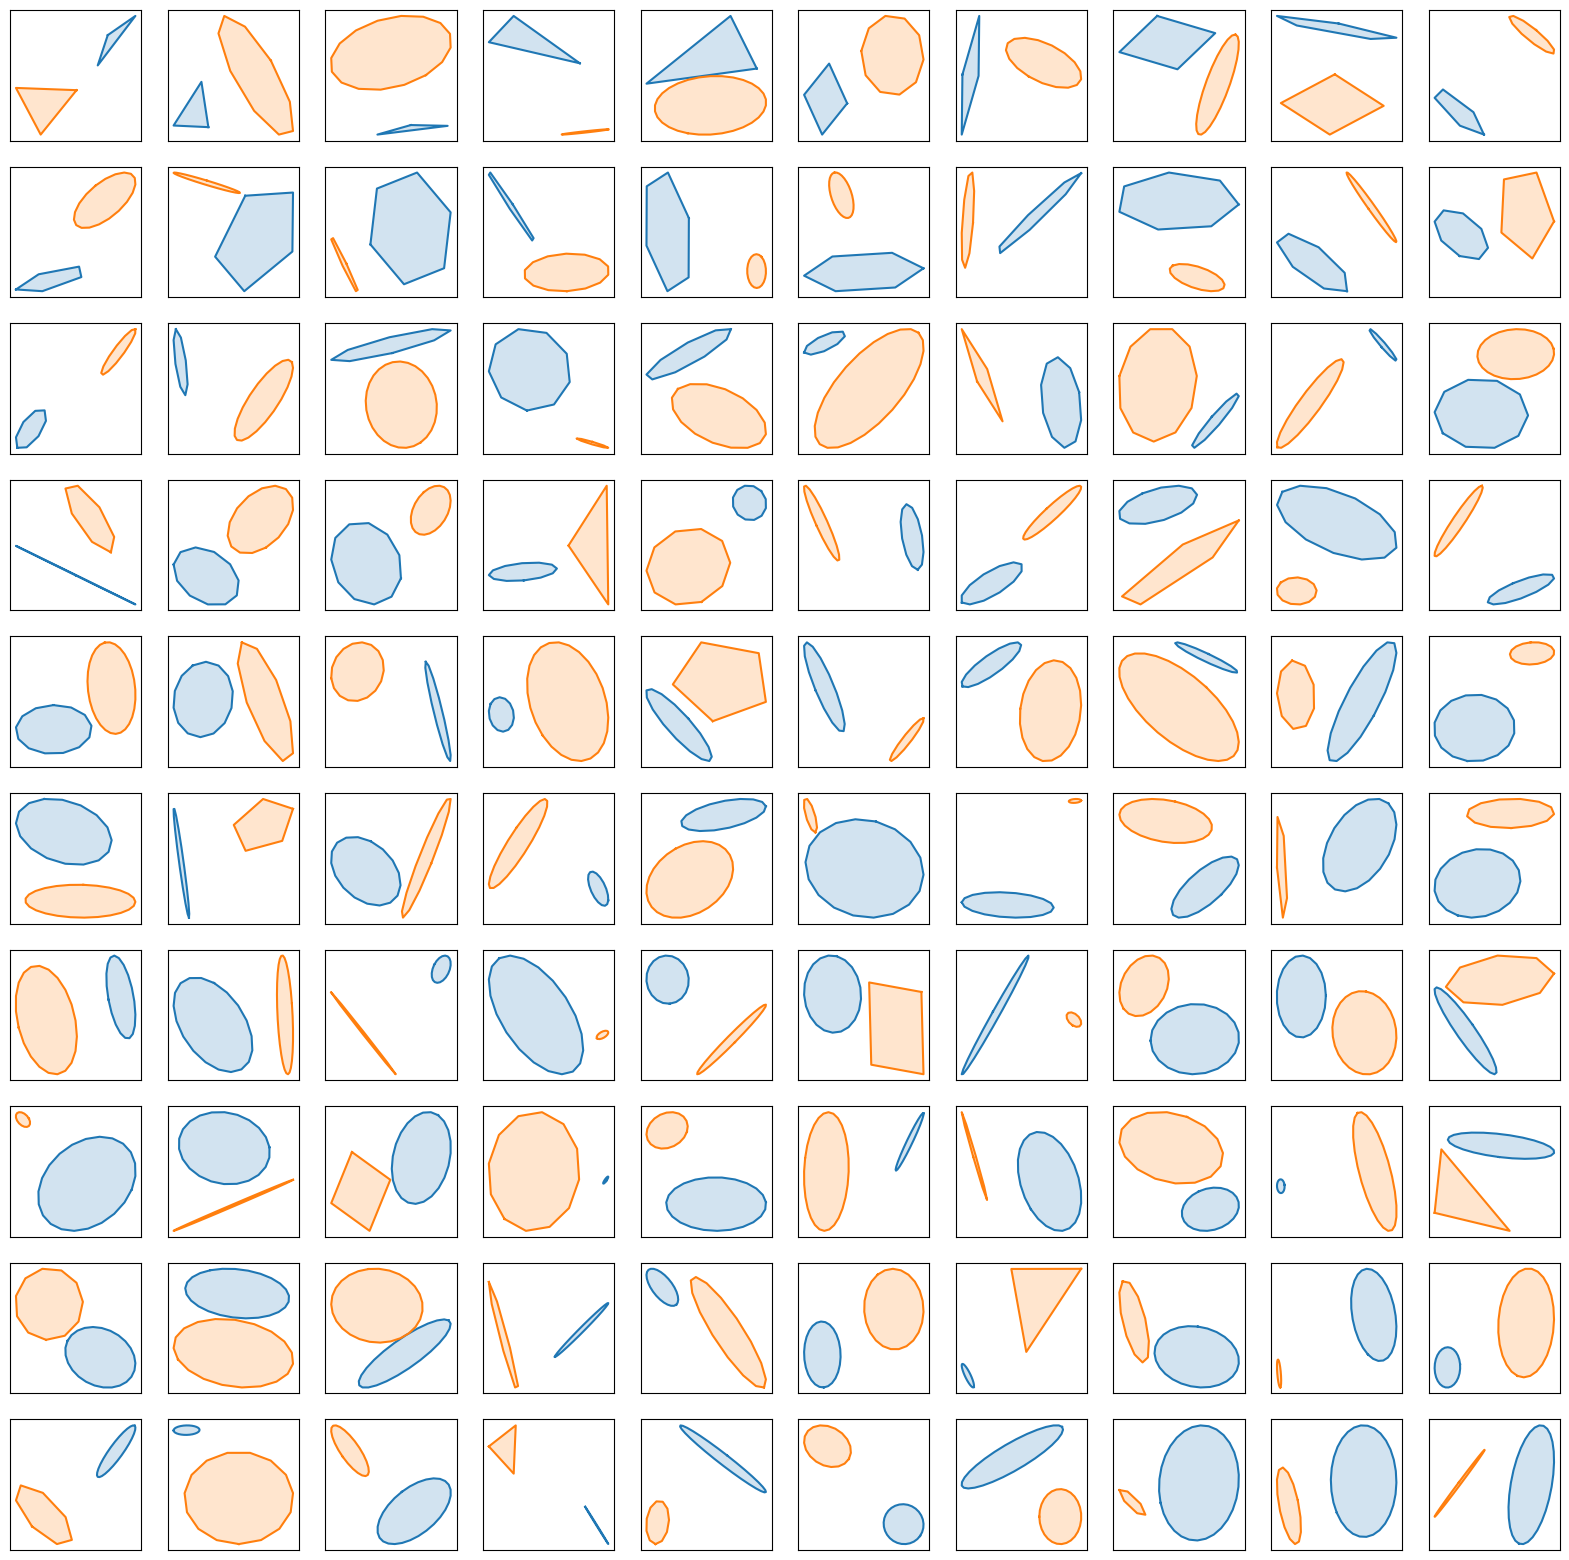

In [40]:
plt.figure(figsize=(20,20))

for i in range(100):
    
    plt.subplot(10, 10, i+1)
    
    el = int(i*len(no)/100)
    Body.draw_several([Body(no[el][0]), Body(no[el][1])])
    plt.xticks([])
    plt.yticks([])

plt.savefig("plots/rand_no_inters_regular.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Time vs $n$

In [14]:
def time_vs_points1(seed=211, min_points=3, max_points=1000, iterations_per_sample=50, m=5):
    random.seed(seed)
    
    hist = []
    
    yes_collisions = 0
    no_collisions = 0
    
    for i in range(min_points, max_points+1):
        
        total_time = 0
        for it in range(iterations_per_sample):
            v1 = generate_random_regular_polygon(i)
            v2 = generate_random_regular_polygon(m)

            body1 = Body(v1)
            body2 = Body(v2)

            start = time.time()
            is_collision, _ = body1.check_collision_gjk(body2)
            end = time.time()
            
            total_time += end-start
            
            if is_collision:
                yes_collisions += 1
            else:
                no_collisions += 1
            
        # average the resulting time
        hist.append([i, total_time/iterations_per_sample])
        print("progress:", 100*(i-min_points)/(max_points-min_points), end="\r")
    
    print()
    print("yes:", yes_collisions)
    print("no:", no_collisions)
    
    return np.array(hist)

In [16]:
hist = time_vs_points1()

progress: 100.096990972918754
yes: 21334
no: 28566


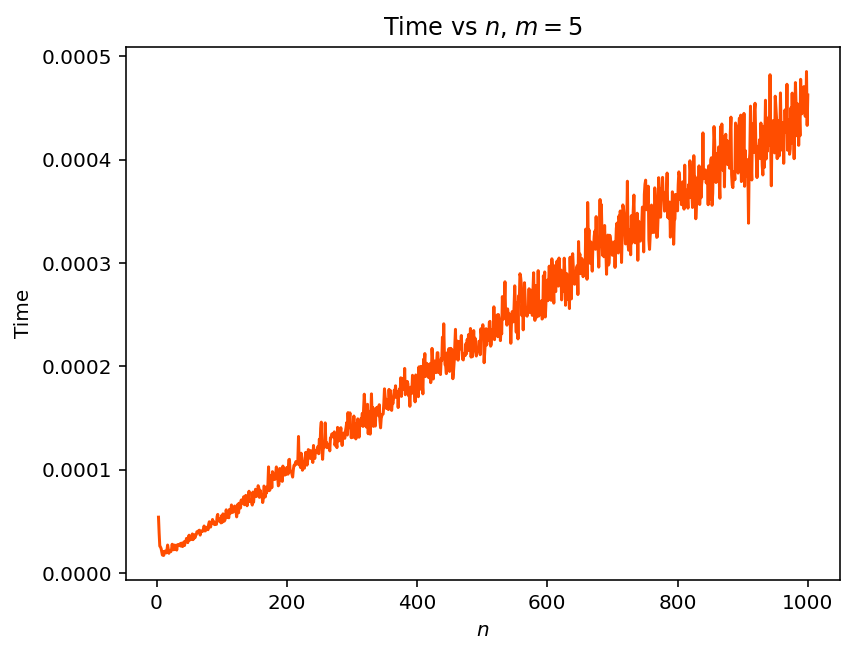

In [17]:
plt.figure('Time vs $n$', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0))

plt.xlabel(r'$n$')
plt.ylabel('Time')
plt.title(r'Time vs $n$, $m=5$')

plt.savefig("plots/time_vs_n.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Number of operations vs $n$

In [15]:
class BodyWithCount:
    def __init__(self, hitBox: List[Vec2D] = None):
        self._hitBox = [] if hitBox is None else hitBox
        
        if(type(hitBox) == np.ndarray):
            self._hitBox = [Vec2D(p[0], p[1]) for p in hitBox]
        
    def draw(self):
        x_list = [v.x for v in self._hitBox]
        y_list = [v.y for v in self._hitBox]
        
        # add the first point to close the figure
        x_list.append(self._hitBox[0].x)
        y_list.append(self._hitBox[0].y)
        
        plt.fill_between(x_list, y_list, alpha=0.2)
        plt.plot(x_list, y_list)
        
        return x_list, y_list
    
    def size(self) -> int:
        return len(self._hitBox)

    def _find_furthest_point(self, direction):
        max_point = Vec2D()
        max_distance = float('-inf')

        for point in self._hitBox:
            distance = point.dot(direction)

            if distance > max_distance:
                max_distance = distance
                max_point = point

        return max_point

    def _support(self, obj, direction: Vec2D) -> Vec2D:
        p1 = self._find_furthest_point(direction)
        p2 = obj._find_furthest_point(-direction)

        return p1 - p2
        
    @staticmethod
    def _next_simplex(simplex, count):
        simplex_type = simplex.type()

        if simplex_type == SimplexType.Line:
            return BodyWithCount._line_case(simplex, count)
        elif simplex_type == SimplexType.Triangle:
            return BodyWithCount._triangle_case(simplex, count)
        else:
            raise ValueError("Body::next_simplex: simplex is not Line or Triangle")

    @staticmethod
    def _line_case(simplex, count):
        
        new_simplex = simplex
        new_direction = Vec2D()

        a = simplex[0]
        b = simplex[1]

        ab = b - a
        ao = -a
        
        ab_n = ab.normal()

        if ab.dot(ao) > 0:
            new_direction = ab_n if ab_n.dot(ao) > 0 else -ab_n
        else:
            new_simplex = Simplex([a])
            new_direction = ao

        return new_simplex, new_direction, False, count+1

    @staticmethod
    def _triangle_case(simplex, count):
                
        new_simplex = simplex
        new_direction = Vec2D()

        a = simplex[0]
        b = simplex[1]
        c = simplex[2]

        ab = b - a
        ac = c - a
        ao = -a
        
        ac_n = ac.normal()

        if ac_n.dot(ao) > 0:
            if ac.dot(ao) > 0:
                new_simplex = Simplex([a, c])
                new_direction = ac_n
            else:
                return BodyWithCount._line_case(Simplex([a, b]), count+1)
        else:
            if ab.normal().dot(ao) < 0:
                # here we need to reverse the order because we can find the next
                # point only in the direction of the -normal of AB
                return BodyWithCount._line_case(Simplex([b, a]), count+1)
            else:
                # Collision detected
                return new_simplex, Vec2D(), True, count+1
        
        return new_simplex, new_direction, False, count+1
    
    @staticmethod
    def draw_several(shapes):
        for shape in shapes:
            shape.draw()

    def check_collision_gjk(self, obj):
        
        count = 0
        
        # Get initial support point in any direction
        support = self._support(obj, Vec2D(1, 0))
        count += self.size() + obj.size()

        # Simplex is an array of points, max count is 4
        simplex = Simplex()
        simplex.push_front(support)

        # New direction is towards the origin
        direction = -support

        iters = 0
        while iters < self.size() + obj.size():
            iters += 1
            support = self._support(obj, direction)
            count += self.size() + obj.size()

            if support.dot(direction) <= 0:
                return False, simplex, count  # no collision

            simplex.push_front(support)

            new_simplex, new_direction, is_found, count = BodyWithCount._next_simplex(simplex, count)

            direction = new_direction
            simplex = new_simplex
            
            if is_found:
                return True, simplex, count
        

        return False, simplex, count

In [16]:
def test_collision_count(x_shift=2.40, y_shift=-0.30):
    body2 = BodyWithCount([Vec2D(-1+x_shift, -1+y_shift), Vec2D(0+x_shift, 1+y_shift), Vec2D(1+x_shift, -1+y_shift)])
    body1 = BodyWithCount([Vec2D(-1, -1), Vec2D(0, 1), Vec2D(1, 1), Vec2D(2, -1)])
    
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    BodyWithCount.draw_several([body1, body2])
    
    is_collision, _, count = body1.check_collision_gjk(body2)
    print("Collision =", is_collision)
    print("Steps =", count)
    
# simple example with trangle and parallelogram 
#widgets.interact(test_collision_count, x_shift=(-3.0, 3.0, 0.3), y_shift=(-3.0, 3.0, 0.3))

In [53]:
def steps_vs_points1(seed=211, min_points=3, max_points=10000, iterations_per_sample=100, m=5):
    random.seed(seed)
    
    hist = []
    
    yes_collisions = 0
    no_collisions = 0
    
    for i in range(min_points, max_points+1):
        
        total_counter = 0
        for it in range(iterations_per_sample):
            v1 = generate_random_regular_polygon(i)
            v2 = generate_random_regular_polygon(m)

            body1 = BodyWithCount(v1)
            body2 = BodyWithCount(v2)

            is_collision, _, count = body1.check_collision_gjk(body2)
            
            total_counter += count
            
            if is_collision:
                yes_collisions += 1
            else:
                no_collisions += 1
            
        # average the resulting time
        hist.append([i, total_counter/iterations_per_sample])
        print("progress:", 100*(i-min_points)/(max_points-min_points), end="\r")
    
    print()
    print("yes:", yes_collisions)
    print("no:", no_collisions)
    
    return np.array(hist)

In [54]:
hist = steps_vs_points1()

progress: 100.0999699909973656
yes: 425804
no: 573996


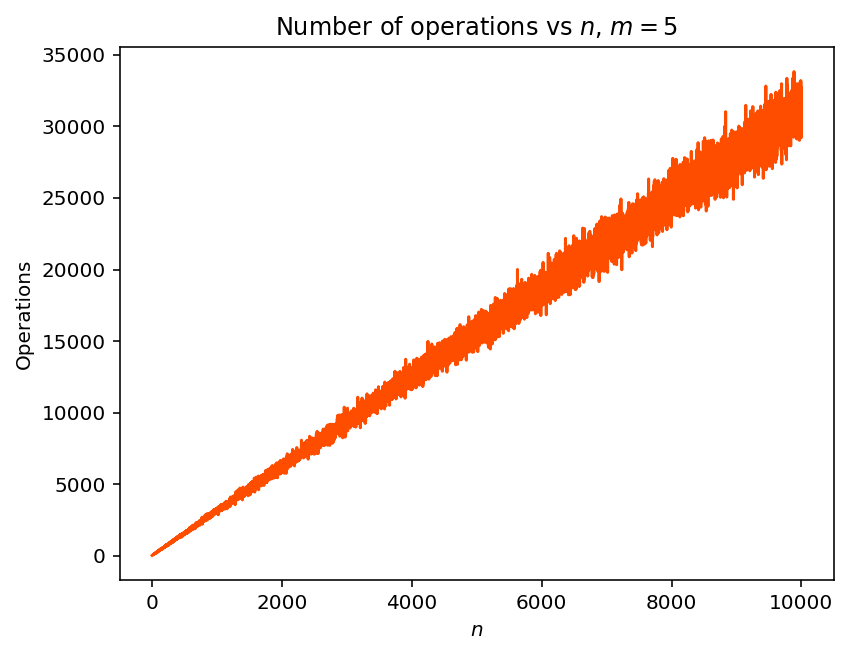

In [55]:
plt.figure('Number of operations vs $n$', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0))

plt.xlabel(r'$n$')
plt.ylabel('Operations')
plt.title(r'Number of operations vs $n$, $m=5$')

plt.show()

In [56]:
A = np.column_stack((hist[:, 0], np.ones(len(hist))))
ATA = A.T@A
y = hist[:, 1]

l = la.inv(ATA)@A.T@y

In [57]:
X = [i for i in range(int(hist[-1, 0]))]
Y = [l[0]*x + l[1] for x in X]

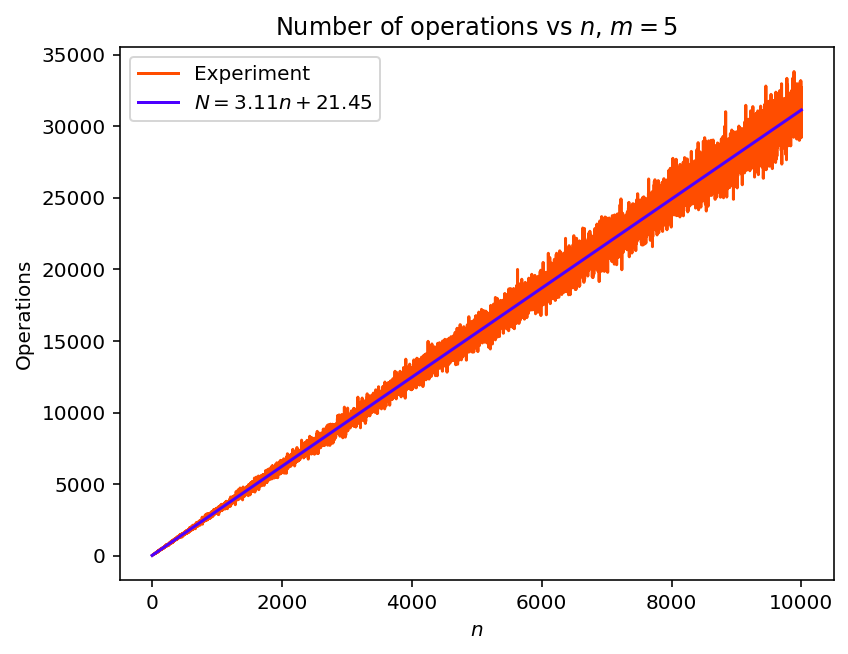

In [58]:
plt.figure('Number of operations vs $n$', dpi=72*2)
plt.plot(hist[:, 0], hist[:, 1], c=(1, 0.3, 0), label="Experiment")
plt.plot(X, Y, c=(0.3, 0, 1), label=r"$N="+str(round(l[0], 2))+"n + " + str(round(l[1], 2)) + "$")

plt.xlabel(r'$n$')
plt.ylabel('Operations')
plt.title(r'Number of operations vs $n$, $m=5$')

plt.legend()

plt.savefig("plots/steps_vs_n_10000_100.pdf", format="pdf", bbox_inches="tight")

plt.show()